In [43]:
import torchvision as t
import torch
import numpy as np
import pandas as pd
#import gpytorch
import math
from matplotlib import pyplot as plt
import urllib.request
import os.path
from scipy.io import loadmat
from math import floor
import time
import gc
import FLOVE

# Graph Builder

In [44]:
class ExactGPModel(FLOVE.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = FLOVE.means.ConstantMean()
        self.covar_module = FLOVE.kernels.ScaleKernel(FLOVE.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return FLOVE.distributions.MultivariateNormal(mean_x, covar_x)
if not os.path.isfile('skillcraft.mat'):
    #print('Downloading \'skillcraft\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1xQ1vgx_bOsLDQ3RLbJwPxMyJHW7U9Eqd', 'skillcraft.mat')
    
    
data = torch.Tensor(loadmat('skillcraft.mat')['data'])
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

In [45]:
temp=100
matrix_data=np.zeros((33,5))
i=0
while temp<=3300:
    
    
    Xt=X.numpy()
    yt=y.numpy()
    Xt=X[:temp]
    yt=y[:temp]
    #print(y)
    Xt=torch.Tensor(Xt)
    yt=torch.Tensor(yt)
    # Use the first 80% of the data for training, and the last 20% for testing.
    train_n = int(floor(0.4*len(Xt)))

    train_x = Xt[:train_n,:].contiguous()
    train_y = yt[:train_n].contiguous()

    test_x = Xt[train_n:,:].contiguous()
    test_y = yt[train_n:].contiguous()

    

    # initialize likelihood and model
    likelihood = FLOVE.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = FLOVE.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 50
    def train():
        for i in range(training_iterations):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
            
            optimizer.step()
            temp=loss.item()
            return temp     
    err=train()


    # Set into eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        start_time = time.time()
        preds = model(test_x)
        exact_covar = preds.covariance_matrix
        exact_covar_time = time.time() - start_time
    # Clear as much 'stuff' as possible
    gc.collect()
    torch.cuda.empty_cache()
    model.train()
    likelihood.train()

    # Set into eval mode
    model.eval()
    likelihood.eval()

    # The 
    with torch.no_grad(), FLOVE.settings.fast_pred_var(1), FLOVE.settings.max_root_decomposition_size(25):
        start_time = time.time()
        preds = model(test_x)
        fast_time_no_cache = time.time() - start_time
    '''
    with torch.no_grad(), FLOVE.settings.fast_pred_var(), FLOVE.settings.max_root_decomposition_size(25):
        start_time = time.time()
        preds = model(test_x)
        fast_covar = preds.covariance_matrix
        fast_time_with_cache = time.time() - start_time
    '''
    print(temp)
    print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))
    print('Time to compute mean + covariances (no cache) {:.2f}s'.format(fast_time_no_cache))
    #print('Time to compute mean + variances (cache): {:.2f}s'.format(fast_time_with_cache))
    #print('MAE between exact covar matrix and fast covar matrix: {}'.format((exact_covar - fast_covar).abs().mean()))
    #print(np.array(preds.loc))
    #print(test_y.numpy()) 
    print('accur: {}'.format(np.linalg.norm(np.array(preds.loc)-test_y.numpy())))
    #np.linalg.norm(np.array(preds.loc)-test_y.numpy())
    matrix_data[i]=[temp,exact_covar_time,fast_time_no_cache,err,(training_iterations+temp*math.log(temp))*0.01]
    i=i+1
    temp=temp+100
    '''(exact_covar - fast_covar).abs().mean(),'''
    '''accuracy_cov':matrix_data[:,3],'''
dd=pd.DataFrame({'N':matrix_data[:,0],'exact_covar_time':matrix_data[:,1],'fast':matrix_data[:,2],'accur':matrix_data[:,3],'nlogn':matrix_data[:,4]})
dd.to_excel('data.xlsx')
#print(matrix_data)

100
Time to compute exact mean + covariances: 0.06s
Time to compute mean + covariances (no cache) 0.02s
accur: 2.7487595081329346
200
Time to compute exact mean + covariances: 0.03s
Time to compute mean + covariances (no cache) 0.02s
accur: 3.2642571926116943
300
Time to compute exact mean + covariances: 0.04s
Time to compute mean + covariances (no cache) 0.02s
accur: 3.5419795513153076
400
Time to compute exact mean + covariances: 0.06s
Time to compute mean + covariances (no cache) 0.03s
accur: 4.159011363983154
500
Time to compute exact mean + covariances: 0.08s
Time to compute mean + covariances (no cache) 0.04s
accur: 4.725274085998535
600
Time to compute exact mean + covariances: 0.11s
Time to compute mean + covariances (no cache) 0.04s
accur: 5.390343189239502
700
Time to compute exact mean + covariances: 0.14s
Time to compute mean + covariances (no cache) 0.04s
accur: 6.115331172943115
800
Time to compute exact mean + covariances: 0.18s
Time to compute mean + covariances (no cac

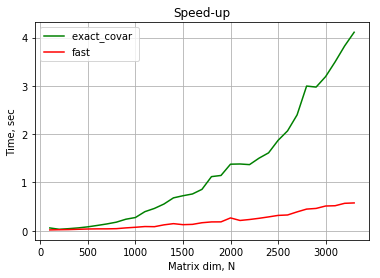

In [46]:
plt.title('Speed-up')
plt.plot(dd['N'].tolist(),dd['exact_covar_time'].tolist(),label='green',color='green')
plt.plot(dd['N'].tolist(),dd['fast'].tolist(),label='red',color='red')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
plt.legend(['exact_covar ','fast'])
plt.xlabel('Matrix dim, N')
plt.ylabel('Time, sec')
plt.grid(True)
#plt.show()
plt.savefig('Speed-up')

In [23]:
'''
plt.title('Matrix difference')
plt.plot(dd['N'].tolist(),dd['accuracy_cov'].tolist(),label='red',color='red')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
plt.xlabel('Matrix dim, N')
plt.ylabel('Distance')
plt.grid(True)
#plt.show()
plt.savefig('Matrix_diff')
'''

"\nplt.title('Matrix difference')\nplt.plot(dd['N'].tolist(),dd['accuracy_cov'].tolist(),label='red',color='red')\n#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())\nplt.xlabel('Matrix dim, N')\nplt.ylabel('Distance')\nplt.grid(True)\n#plt.show()\nplt.savefig('Matrix_diff')\n"

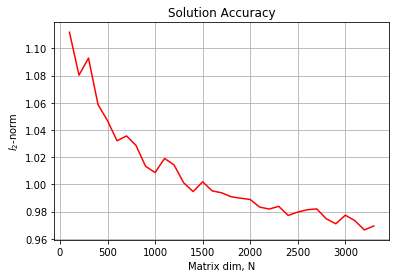

In [14]:
plt.title('Solution Accuracy')
plt.plot(dd['N'].tolist(),dd['accur'].tolist(),label='red',color='red')
plt.xlabel('Matrix dim, N')
plt.ylabel('$l_2$-norm')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
plt.grid(True)
#plt.show()
plt.savefig('Solution_acc')

# For Lanczos iteration

In [48]:
 
if not os.path.isfile('skillcraft.mat'):
    #print('Downloading \'skillcraft\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1xQ1vgx_bOsLDQ3RLbJwPxMyJHW7U9Eqd', 'skillcraft.mat')


data = torch.Tensor(loadmat('skillcraft.mat')['data'])

#print(y)
#print(X)
#print(data.shape)
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]
# Use the first 80% of the data for training, and the last 20% for testing.
train_n = int(floor(0.4*len(X)))

train_x = X[:train_n,:].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:,:].contiguous()
test_y = y[train_n:].contiguous()

class ExactGPModel(FLOVE.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = FLOVE.means.ConstantMean()
        self.covar_module = FLOVE.kernels.ScaleKernel(FLOVE.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return FLOVE.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = FLOVE.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = FLOVE.mlls.ExactMarginalLogLikelihood(likelihood, model)

temp=10
matrix_data=np.zeros((100,2))
i=0 
while temp<=1000:
    def train():
        for i in range(training_iterations):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))

            optimizer.step()
            return loss.item()  
    err=train()
    matrix_data[i]=[temp,err]
    i=i+1
    temp=temp+10

# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    start_time = time.time()
    preds = model(test_x)
    exact_covar = preds.covariance_matrix
    exact_covar_time = time.time() - start_time
#print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))
# Clear as much 'stuff' as possible
gc.collect()
torch.cuda.empty_cache()
model.train()
likelihood.train()

# Set into eval mode
model.eval()
likelihood.eval()

# The 
#temp=10
#matrix_data=np.zeros((100,2))
#i=0 
#while temp<=1000:
with torch.no_grad(), FLOVE.settings.fast_pred_var(), FLOVE.settings.max_root_decomposition_size(25):#, FLOVE.settings.max_lanczos_quadrature_iterations(temp):
    #print(FLOVE.settings.max_lanczos_quadrature_iterations(temp))
    start_time = time.time()
    preds = model(test_x)
    fast_time_no_cache = time.time() - start_time
        #err=np.linalg.norm(np.array(preds.loc)-test_y.numpy())
        #print(err)
        #matrix_data[i]=[temp,err]
        #i=i+1
        #temp=temp+10

    
dd=pd.DataFrame({'iter':matrix_data[:,0],'err':matrix_data[:,1]})
dd.to_excel('data_ert.xlsx')

with torch.no_grad(), FLOVE.settings.fast_pred_var(), FLOVE.settings.max_root_decomposition_size(25):
    start_time = time.time()
    preds = model(test_x)
    fast_covar = preds.covariance_matrix
    fast_time_with_cache = time.time() - start_time

print(temp)
print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))
#print('Time to compute without uskorenie {:.2f}s'.format(time_train_without_smth))
print('Time to compute mean + covariances (no cache) {:.2f}s'.format(fast_time_no_cache))
#print('Time to compute mean + variances (cache): {:.2f}s'.format(fast_time_with_cache))
print('MAE between exact covar matrix and fast covar matrix: {}'.format((exact_covar - fast_covar).abs().mean()))
#print(np.array(preds.loc))
#print(test_y.numpy()) 
print('accur: {}'.format(np.linalg.norm(np.array(preds.loc)-test_y.numpy())))
#np.linalg.norm(np.array(preds.loc)-test_y.numpy())

#print(matrix_data)

1010
Time to compute exact mean + covariances: 4.00s
Time to compute mean + covariances (no cache) 0.57s
MAE between exact covar matrix and fast covar matrix: 0.0005725229857489467
accur: 11.351877212524414


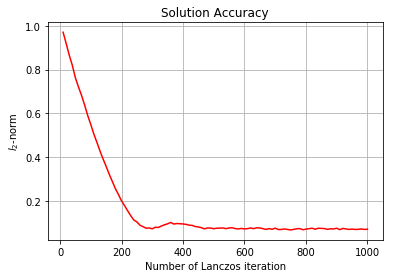

In [49]:
plt.title('Solution Accuracy')
plt.plot(dd['iter'].tolist(),dd['err'].tolist(),label='red',color='red')
plt.xlabel('Number of Lanczos iteration')
plt.ylabel('$l_2$-norm')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
plt.grid(True)
#plt.show()
plt.savefig('Number of Lanczos iter')

In [219]:
from FLOVE.functions import _inv_quad_log_det
from FLOVE.utils import lanczos
from FLOVE.utils.lanczos import lanczos_tridiag,lanczos_tridiag_to_diag
from FLOVE.utils.eig import batch_symeig
import torch
from torch.autograd import Function
from FLOVE.utils.stochastic_lq import StochasticLQ
from FLOVE.utils import linear_cg
from FLOVE import settings

import numpy as np
import scipy as sp
n=1000
max_iter=2*n
R=np.random.rand(n,n)
R=np.dot(R.T,R)
def matmul(b):
    Temp=torch.Tensor(R)
    return torch.matmul(Temp,b)

#Q=stochastic_lq.StochasticLQ(max_iter=it,num_random_probes=num_rand_v)
#eigenvalues,eigenvectors=lanczos_tridiag_to_diag(tridiag)
#A=InvQuadLogDet()
#Q.evaluate(tridiag.shape,diag,eige,[lambda x: x.log()])
#print(Q.evaluate(R.shape,))

q_mat,t_mat=lanczos_tridiag(matmul,max_iter=max_iter,dtype=torch.float32,device='cpu',matrix_shape=R.shape)
#eigenvalues, eigenvectors = lanczos_tridiag_to_diag(t_mat)
q_mat=q_mat.numpy()
t_mat=t_mat.numpy()
eigenvalues, eigenvectors=np.linalg.eig(t_mat)
#print(eigenvalues)
eigenvalues=torch.Tensor(eigenvalues)
eigenvectors=torch.Tensor(eigenvectors)
'''
it=500
num_rand_v=10
max_iter=it,num_random_probes=num_rand_v
'''
#print(t_mat.numpy().shape)
#print(eigenvalues.shape)
#print(eigenvectors.shape)
slq = StochasticLQ()


def slq(num_random_probes,eigenvalues,eigenvectors,matrix_shape):
    eigenvalues=eigenvalues.numpy()
    eigenvectors=eigenvectors.numpy()
    batch_shape = eigenvalues.shape[1:-1]
    log_det=0
    #print(eigenvalues)
    for j in range(num_random_probes):
        
        temp=np.random.normal(loc=0.0, scale=2.0, size=matrix_shape)
        #temp=eigenvectors[j]
        eigenvectors_for_probe = temp/np.linalg.norm(temp)
        eigenvecs_first_component = np.dot(eigenvectors.T,eigenvectors_for_probe)
        for i in range(eigenvalues.shape[0]):
            # num_random_probes<=N - shape of matrix
            eigenvalues_for_probe = eigenvalues[i]
            func_eigenvalues = np.log(eigenvalues_for_probe)
            mu_i=eigenvecs_first_component[i]
            dot_products = (mu_i**2)* func_eigenvalues
            log_det = log_det + matrix_shape*1.0 / num_random_probes* dot_products
    return log_det


log_det_term=slq(max_iter,eigenvalues,eigenvectors,eigenvectors.numpy().shape[0])
print(log_det_term)

#Log_det=_inv_quad_log_det.InvQuadLogDet().forward(R,dtype=torch.float32,device='cpu',matrix.shape=R.shape,log_det=True, inv_quad=False)

3432.517562718234


In [220]:
s,log=np.linalg.slogdet(R)
print(log)

3431.6077295541386


In [208]:
np.random.rand(100000).mean()

0.4998955345411528

In [209]:
eigenvalues, eigenvectors = lanczos_tridiag_to_diag(t_mat)
v,w=np.linalg.eig(t_mat)

print(np.linalg.norm(v-eigenvalues.numpy()))
print(np.linalg.norm(w-eigenvectors.numpy()))

78.13919
12.369317
